# Import Library

In [1]:
import os 
from datetime import datetime, timedelta, date

# 전처리
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# 모델
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# 평가
from sklearn import metrics

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import pyecharts as pye

# warnings
import warnings
warnings.filterwarnings('ignore')

---

## Load Data

In [2]:
data = pd.read_csv('../dataset/train.csv', index_col='game_id')
print('data size : ',data.shape)

data size :  (2013, 16)


In [3]:
today = datetime.today().strftime('%Y%m%d')

---

## Data information
- 데이터 수집기간은 2017-03-31~{{ today }}일까지이고 {{ data.shape[0] }}번의 경기와 {{ data.shape[1] }}개의 변수로 이루어져 있습니다.
- 결측치는 없습니다.
- 변수설명의 특이사항은 2019년부터 `넥센`이 팀명을 `키움`으로 바꾸면서 2017~2019까지 팀명이 총 11개팀입니다.

Name | Description
---|---
game_id | 게임별 고유 아이디
date | 날짜
weeks | 요일
weekend_is | 주말 여부 
home_win | 홈팀 승률
away_win | 방문팀 승률
stadium | 구장
region | 지역
avg_temp | 전날 평균기온(ºC)
min_temp | 전날 최소기온(ºC)
max_temp | 전날 최대기온(ºC)
rainfall | 전날 강수량(mm)
avg_windspeed  | 전날 상대습도(%)
nb_crowd | 관중객 수

---
**CODE 설명**
- `DataFrame.info()`는 해당 테이블의 정보를 반환해줍니다. 각 변수별 관측치 수와 결측값 여부 그리고 타입을 나타냅니다.
- `DataFrame.describe`는 해당 테이블의 통계치를 반환합니다.
    - `include`가 'all'인 경우 모든 타입의 통계치를 반환합니다. 숫자형자료의 경우 최소값,최대값,중위값,1분위수,3분위수,평균,표준편차를 나타내고, 범주형자료의 경우 level 수, 빈도수가 가장 큰 범주, 최빈값을 반환합니다.

---

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2013 entries, 1 to 2009
Data columns (total 16 columns):
date                  2013 non-null object
weeks                 2013 non-null object
region                2013 non-null object
stadium               2013 non-null object
home                  2013 non-null object
home_win              2013 non-null float64
away                  2013 non-null object
away_win              2013 non-null float64
weekend_is            2013 non-null int64
avg_temp              2008 non-null float64
min_temp              2008 non-null float64
max_temp              2008 non-null float64
rainfall              2008 non-null float64
avg_windspeed         2008 non-null float64
avg_relative_humid    2008 non-null float64
nb_crowd              2013 non-null int64
dtypes: float64(8), int64(2), object(6)
memory usage: 267.4+ KB


In [5]:
data.describe(include='all')

,date,weeks,region,stadium,home,home_win,away,away_win,weekend_is,avg_temp,min_temp,max_temp,rainfall,avg_windspeed,avg_relative_humid,nb_crowd
count,2013,2013,2013,2013,2013,2013.000000,2013,2013.000000,2013.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2013.000000
unique,432,7,11,13,10,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2018-10-06,Saturday,Seoul,Jamsil,NEXEN,NaN,KT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,8,352,610,402,208,NaN,208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,0.496307,NaN,0.496896,0.340785,20.939392,16.672311,26.048556,2.545618,2.212450,65.335259,11153.718828
std,NaN,NaN,NaN,NaN,NaN,0.131746,NaN,0.132919,0.474091,5.844667,6.388724,5.845811,10.716421,0.997173,15.179793,5635.492255
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,3.300000,-1.100000,7.400000,0.000000,0.400000,20.500000,1158.000000
25%,NaN,NaN,NaN,NaN,NaN,0.424000,NaN,0.423000,0.000000,17.200000,12.000000,22.500000,0.000000,1.500000,54.400000,7012.000000
50%,NaN,NaN,NaN,NaN,NaN,0.496000,NaN,0.495000,0.000000,21.500000,17.300000,26.600000,0.000000,2.000000,65.900000,9805.000000
75%,NaN,NaN,NaN,NaN,NaN,0.570000,NaN,0.574000,1.000000,25.000000,21.400000,29.900000,0.100000,2.600000,76.400000,14364.000000


---

# 데이터 전처리 [Preprocessing]

## 시간 타입
시계열 변수 타입은 시간별 데이터 특성을 보기위한 타입입니다.

**CODE설명**
- `pd.to_datetime`은 변수 타입을 시계열로 변환합니다.

In [6]:
data['date'] = pd.to_datetime(data.date)

In [7]:
data['year'] = data.date.dt.year
data['month'] = data.date.dt.month

---
# 탐색적자료분석 [Exploratary Data Analysis]
---

> **탐색적 자료 분석이란?**  
     데이터를 학습하기 전에 데이터를 확인하는 작업을 말합니다. 탐색적 자료분석에서 봐야할 것들은 크게 3가지입니다.
     1. 데이터의 특성이 어떤가
     2. 변수간 특정 관계가 있는가
     3. 목표변수에 영향이 있는 변수가 있는가

> **시각화(visualization)는 왜 하는 것일까?**
- 데이터 분석은 **패턴**을 찾는 것이 핵심입니다.  
    ex) 어떤 특징을 가진 선수가 이적료가 높은지? 낮은지?
    
    
- 이러한 패턴을 가장 쉽게 눈으로 확인할 수 있는 방법 중 하나가 바로 **시각화**입니다. 

![이미지](https://drive.google.com/uc?export=view&id=1kqqvSxM9eJrL-bnX_YqoldCZSgrQ-OGD)




1. 각 변수별 특징은 어떤가?
2. 일년 중 언제 사람들은 야구를 많이 보러갈까?
3. 야구를 보러가는 날이 지역에 따라 차이가 있을까?
4. 구장에 따라 차이가 더 있을까?
5. 지역과 구장이 아닌 날씨에 영향을 많이 받을까?
6. 날씨에 영향을 받는다면 어떤 요소에 영향을 받을까?

## 각 변수별 특징

In [8]:
num_stadium = data.stadium.nunique()
num_region = data.region.nunique()

In [9]:
stadium_bar = pye.Bar('구장별 특성')
stadium_cnt = data.stadium.value_counts()
attrs = stadium_cnt.index
values = stadium_cnt.values
stadium_bar.add('', attrs, values, mark_point=['max','min'])

region_bar = pye.Bar('지역별 특성', title_top='50%')
region_cnt = data.region.value_counts()
attrs = region_cnt.index
values = region_cnt.values
region_bar.add('', attrs, values, mark_point=['max','min'])

grid1 = pye.Grid(height=500)
grid1.add(stadium_bar, grid_bottom='60%')
grid1.add(region_bar, grid_top='60%')
grid1

- 구장의 개수 {{ num_stadium }}개, 잠실에서 가장 많이 경기 399번. 청주에서 가장 적게 경기 16번
- 지역별 개수 {{ num_region }}개, 서울에서 가장 많이 경기 604번. 청주에서 가장 적게 경기 16번

In [10]:
weeks_bar = pye.Bar('요일별 특성')
weeks_cnt = data.weeks.value_counts()
attrs = weeks_cnt.index
values = weeks_cnt.values
weeks_bar.add('', attrs, values, mark_point=['max','min'])

weekend_is_pie = pye.Pie('평일/주말 특성', title_pos='60%')
weekend_is_cnt = data.weekend_is.value_counts()
attrs = ['평일','주말']
values = weekend_is_cnt.values
weekend_is_pie.add('', 
                   attrs, 
                   values, 
                   center=[75, 50], 
                   radius=[15,55], 
                   rosetype='radius', 
                   is_legend_show=False, 
                   is_label_show=True)

grid2 = pye.Grid(width=800)
grid2.add(weeks_bar, grid_right='55%')
grid2.add(weekend_is_pie, grid_left='60%')
grid2

- 월요일은 원래 경기가 없음. 그러나 특별히 경기가 이루어진 경우가 있음. 시즌 마지막
- 당연히 주말보다 평일이 더 많음.

In [11]:
teams_year = pd.concat([data[['year','home']].rename(columns={'home':'team'}),
                        data[['year','away']].rename(columns={'away':'team'})],
                        axis=0)
timeline1 = pye.Timeline(is_auto_play=True, timeline_bottom=0)

for y in [2017, 2018, 2019]:
    teams_bar = pye.Bar('{}년 팀별 경기 수'.format(y))
    teams = teams_year.loc[teams_year.year==y, 'team'].value_counts()
    teams_bar.add('', teams.index, teams.values, mark_point=['max','min'])
    timeline1.add(teams_bar, str(y))

timeline1

In [12]:
team_names = data.home.unique()

page1 = pye.Page()

line2017 = pye.Line('2017년 팀별 승률', title_top='5%')
for team_name in team_names:
    # win percentage by team
    team_home = data.loc[(data.year==2017)&(data.home==team_name), ['date','home','home_win']].rename(columns={'home':'team','home_win':'win'})
    team_away = data.loc[(data.year==2017)&(data.away==team_name), ['date','away','away_win']].rename(columns={'away':'team','away_win':'win'})
    team_win = pd.concat([team_home, team_away], axis=0).sort_values(by='date')
    
    # add line plot
    attrs = team_win.date.astype(str)
    values = team_win.win.round(2)
    line2017.add(team_name, attrs, values, mark_point=['max','min'], is_datazoom_show=True)

line2018 = pye.Line('2018년 팀별 승률', title_top='5%')
for team_name in team_names:
    # win percentage by team
    team_home = data.loc[(data.year==2018)&(data.home==team_name), ['date','home','home_win']].rename(columns={'home':'team','home_win':'win'})
    team_away = data.loc[(data.year==2018)&(data.away==team_name), ['date','away','away_win']].rename(columns={'away':'team','away_win':'win'})
    team_win = pd.concat([team_home, team_away], axis=0).sort_values(by='date')
    
    # add line plot
    attrs = team_win.date.astype(str)
    values = team_win.win.round(2)
    line2018.add(team_name, attrs, values, mark_point=['max','min'], is_datazoom_show=True)

line2019 = pye.Line('2019년 팀별 승률', title_top='5%')
for team_name in team_names:
    # win percentage by team
    team_home = data.loc[(data.year==2019)&(data.home==team_name), ['date','home','home_win']].rename(columns={'home':'team','home_win':'win'})
    team_away = data.loc[(data.year==2019)&(data.away==team_name), ['date','away','away_win']].rename(columns={'away':'team','away_win':'win'})
    team_win = pd.concat([team_home, team_away], axis=0).sort_values(by='date')
    
    # add line plot
    attrs = team_win.date.astype(str)
    values = team_win.win.round(2)
    line2019.add(team_name, attrs, values, mark_point=['max','min'], is_datazoom_show=True)

page1.add(line2017)
page1.add(line2018)
page1.add(line2019)
page1

In [13]:
timeline2 = pye.Timeline(is_auto_play=True, timeline_bottom=0)

temp_line = pye.Line('시간별 평균온도 변화')
temp_df = data[['date', 'weeks', 'avg_temp']].groupby(['date','weeks']).mean().reset_index().sort_values(by='date')
attrs = temp_df[['date','weeks']].apply(lambda x: '{}({})'.format(x.date.strftime('%Y%m%d'), x.weeks), axis=1)
values = temp_df['avg_temp'].round(2)
temp_line.add('평균온도', attrs, values, mark_point=['max','min'], is_datazoom_show=True)

rain_line = pye.Line('시간별 강수량 변화')
rain_df = data[['date', 'weeks', 'rainfall']].groupby(['date','weeks']).mean().reset_index().sort_values(by='date')
attrs = rain_df[['date','weeks']].apply(lambda x: '{}({})'.format(x.date.strftime('%Y%m%d'), x.weeks), axis=1)
values = rain_df['rainfall'].round(2)
rain_line.add('강수량', attrs, values, mark_point=['max','min'], is_datazoom_show=True)

wind_line = pye.Line('시간별 풍속 변화')
wind_df = data[['date', 'weeks', 'avg_windspeed']].groupby(['date','weeks']).mean().reset_index().sort_values(by='date')
attrs = wind_df[['date','weeks']].apply(lambda x: '{}({})'.format(x.date.strftime('%Y%m%d'), x.weeks), axis=1)
values = wind_df['avg_windspeed'].round(2)
wind_line.add('풍속', attrs, values, mark_point=['max','min'], is_datazoom_show=True)

humid_line = pye.Line('시간별 습도 변화')
humid_df = data[['date', 'weeks', 'avg_relative_humid']].groupby(['date','weeks']).mean().reset_index().sort_values(by='date')
attrs = humid_df[['date','weeks']].apply(lambda x: '{}({})'.format(x.date.strftime('%Y%m%d'), x.weeks), axis=1)
values = humid_df['avg_relative_humid'].round(2)
humid_line.add('습도', attrs, values, mark_point=['max','min'], is_datazoom_show=True)

timeline2.add(rain_line, '강수량')
timeline2.add(wind_line, '풍속')
timeline2.add(humid_line, '상대습도')
timeline2.add(temp_line, '온도')
timeline2

## 언제 가장 야구를 보러 많이 갈까?

In [14]:
crowd_line = pye.Line('일별 관중 수')
crowd_df = data[['date','weeks','nb_crowd']].groupby(['date','weeks']).sum().reset_index().sort_values(by='date')
attrs = crowd_df[['date','weeks']].apply(lambda x: '{}({})'.format(x.date.strftime('%Y%m%d'), x.weeks), axis=1)
values = crowd_df.nb_crowd
crowd_line.add('관중 수',
              attrs,
              values,
              mark_point=['max','min'],
              is_datazoom_show=True,
              mork_point_symbolsize=80)
crowd_line

주말에 가까울수록 관중수가 늘어나고 주로 토요일이 일주일중 가장 야구를 많이 보러간다.

## 시기에 따라서 관중객 수가 구장별로 다를까?

In [15]:
stadium_names = data.stadium.unique()

stadium_line = pye.Line()
for stadium_name in stadium_names:
    # win percentage by stadium
    stadium_crowd = data.loc[(data.stadium==stadium_name), ['date','weeks','stadium','nb_crowd']]
    
    # add line plot
    attrs = stadium_crowd[['date','weeks']].apply(lambda x: '{}({})'.format(x.date.strftime('%Y%m%d'), x.weeks), axis=1)
    values = stadium_crowd.nb_crowd.round(2)
    stadium_line.add(stadium_name, attrs, values, mark_point=['max','min'], is_datazoom_show=True)
stadium_line

In [16]:
region_names = data.region.unique()

region_line = pye.Line()
for region_name in region_names:
    # win percentage by team
    region_crowd = data.loc[(data.region==region_name), ['date','weeks','region','nb_crowd']]
    
    # add line plot
    attrs = region_crowd[['date','weeks']].apply(lambda x: '{}({})'.format(x.date.strftime('%Y%m%d'), x.weeks), axis=1)
    values = region_crowd.nb_crowd.round(2)
    region_line.add(region_name, attrs, values, mark_point=['max','min'], is_datazoom_show=True)
region_line

## 전날 날씨가 온 경우가 관중객 수에 영향을 미칠까?

In [17]:
timeline3 = pye.Timeline(is_auto_play=True, timeline_bottom=0)

# crowd bar
crowd_bar = pye.Bar('일별 관중 수')
crowd_df = data[['date','weeks','nb_crowd']].groupby(['date','weeks']).sum().reset_index().sort_values(by='date')
attrs = crowd_df[['date','weeks']].apply(lambda x: '{}({})'.format(x.date.strftime('%Y%m%d'), x.weeks), axis=1)
values = crowd_df.nb_crowd
crowd_bar.add('관중 수',
              attrs,
              values,
              mark_point=['max','min'],
              is_datazoom_show=True,
              mark_point_symbolsize=80)

temp_overlap = pye.Overlap()
temp_overlap.add(temp_line)
temp_overlap.add(crowd_bar, is_add_yaxis=True, yaxis_index=1)

rain_overlap = pye.Overlap()
rain_overlap.add(rain_line)
rain_overlap.add(crowd_bar, is_add_yaxis=True, yaxis_index=1)

wind_overlap = pye.Overlap()
wind_overlap.add(wind_line)
wind_overlap.add(crowd_bar, is_add_yaxis=True, yaxis_index=1)

humid_overlap = pye.Overlap()
humid_overlap.add(humid_line)
humid_overlap.add(crowd_bar, is_add_yaxis=True, yaxis_index=1)

timeline3.add(rain_overlap, '강수량')
timeline3.add(wind_overlap, '풍속')
timeline3.add(humid_overlap, '상대습도')
timeline3.add(temp_overlap, '온도')
timeline3

# 더미변환 [Dummy Transform]
- 더미변환은 범주형자료를 변환하는 방법 중 하나입니다.  
- 방법은 k개의 범주를 갖는 변수를 k-1개의 더미변수로 변환 합니다.
- 아래 예시와 같이 범주형 자료가 4가지 카테고리인 경우 3차원 백터로 변환하는 과정을 말합니다.
![](../images/dummy.JPG)
- 더 자세한 내용이 궁금하신분은 아래 링크를 통해 확인하시면 됩니다.  
http://blog.naver.com/PostView.nhn?blogId=leerider&logNo=100190195555   
- Team의 경우 홈팀과 방문팀을 k개의 더미변수로 변환하여 더해줍니다.
- ex) 홈팀: [0,0,0,1,0], 방문팀: [0,1,0,0,0] => 팀: [0,1,0,1,0]

---
**CODE설명**
- `pd.get_dummies`는 위에서 설명한 내용을 적용하는 함수입니다. 
    - `drop_first`가 True인 경우 k-1개의 더미변수를 변환하고, False인 경우 k개의 더미변수로 변환합니다.
- `DataFrame.head()`는 해당 테이블의 상위 n개의 데이터를 반환합니다. default는 5개를 반환합니다.

In [18]:
# stadium
stadium_dummy = pd.get_dummies(data.stadium, drop_first=True)
data = pd.concat([data, stadium_dummy],axis=1)

# region
region_dummy = pd.get_dummies(data.region, drop_first=True)
data = pd.concat([data, region_dummy],axis=1)

# away
away_dummy = pd.get_dummies(data.away, drop_first=True)
data = pd.concat([data, away_dummy],axis=1)

# weeks
weeks_dummy = pd.get_dummies(data.weeks, drop_first=True)
data = pd.concat([data, weeks_dummy],axis=1)

In [19]:
pd.concat([data['stadium'].head(), stadium_dummy.head()], axis=1)

,stadium,Chungju,Daegu,Daejeon,Gocheok,Gwangju,Jamsil,Masan,Munhak,Pohang,Sajik,Suwon,Ulsan
game_id,,,,,,,,,,,,,
1,Jamsil,0,0,0,0,0,1,0,0,0,0,0,0
2,Daegu,0,1,0,0,0,0,0,0,0,0,0,0
3,Munhak,0,0,0,0,0,0,0,1,0,0,0,0
4,Gocheok,0,0,0,1,0,0,0,0,0,0,0,0
5,Masan,0,0,0,0,0,0,1,0,0,0,0,0


In [20]:
data = data.drop(['weeks','region','stadium','home','away'], axis=1)

# 검증데이터 [Validation Set]
--- 
## `머신러닝이란?`
- 데이터 속에서 패턴을 발견하는 것
- 머신러닝은 크게 두 가지로 나누어집니다. 
    > **지도학습(Supervised Learning)** : 예측하고자하는 대상이 있는 경우  
    > **비지도학습(Unsupervised Learning)** : 예측하고자하는 대상이 없는 경우
    
    
- 우리가 풀고자하는 문제는 KBO 야구 관중수를 예측하고자 하는 것이기 때문에 지도학습(Supervised Learning)에 해당합니다. 

---
## 머신러닝 모델이란?
- 데이터를 통해 패턴을 학습할 객체를 말합니다.
- 예를 들어 학교에서 수업을 듣는 학생도 학습할 객체라 할 수 있고, 수행목적이 입력될 로봇도 객체라 할 수 있습니다.
![](https://drive.google.com/uc?export=view&id=1xTTP3m1iQYq4wGqAeKNaS6itVbZNkmul)
---

## 머신러닝 방법이란?
- 머신러닝을 하기위한 방법 또는 알고리즘을 말합니다 
- 예시로는 아래와 같이 Linear Regression(선형회귀), Decision Tree(의사결정나무), Artificial Neural Network(인공신경망)이 있고, 이외에도 더 많은 머신러닝 방법이 있습니다.
> **Linear Regression(선형회귀)**  ![](https://drive.google.com/uc?export=view&id=1WJ_CWhVgIUEPpuEIDv2VmNRR9aZEfVEP
)
> **Decision Tree(의사결정나무)** ![](https://drive.google.com/uc?export=view&id=1f0CIEwzG0YXQvHL3hSW2uzycoHirL_EO
)
> **Artificial Neural Network(인공신경망)** ![](https://drive.google.com/uc?export=view&id=1YVv1o6ENP3KACcxJK9bXm_JF0oAZlICP
)

--- 
## Train data(학습 데이터)와 Test set(평가 데이터)

- 두 데이터 간의 차이는 무엇일까요?
- 바로 예측하려는 목표 데이터가 있는지 없는지입니다.

![](https://drive.google.com/uc?export=view&id=1VgRTfauvVuLgR5P6iXNaz4iMtrYT62W_)

**학습데이터 변수들**

In [21]:
data.columns.tolist()

['date',
 'home_win',
 'away_win',
 'weekend_is',
 'avg_temp',
 'min_temp',
 'max_temp',
 'rainfall',
 'avg_windspeed',
 'avg_relative_humid',
 'nb_crowd',
 'year',
 'month',
 'Chungju',
 'Daegu',
 'Daejeon',
 'Gocheok',
 'Gwangju',
 'Jamsil',
 'Masan',
 'Munhak',
 'Pohang',
 'Sajik',
 'Suwon',
 'Ulsan',
 'Changwon',
 'Chungju',
 'Daegu',
 'Daejeon',
 'Gwangju',
 'Incheon',
 'Pohang',
 'Seoul',
 'Suwon',
 'Ulsan',
 'HANHWA',
 'KIA',
 'KT',
 'LG',
 'LOTTE',
 'NC',
 'NEXEN',
 'SAMSUNG',
 'SK',
 'Monday',
 'Saturday',
 'Sunday',
 'Thursday',
 'Tuesday',
 'Wednesday']

In [22]:
# set index 
data = data.set_index('date')

# split test
yesterday = date.today() - timedelta(1)
train = data[data.index < datetime(2019,8,13)]
test = data[data.index == datetime(2019,8,13)]

In [23]:
x_train, x_valid, y_train, y_valid = train_test_split(train.drop('nb_crowd',axis=1), 
                                                      train.nb_crowd, 
                                                      test_size=0.2, 
                                                      random_state=223)

In [24]:
print('x_train size: ',x_train.shape[0])
print('x_valid size: ',x_valid.shape[0])

x_train size:  1588
x_valid size:  398


# 모델링 [Build a Model]

---
**CODE설명**

```python
from sklearn.linear_model import LinearRegression

model = LinearRegression() # 선형회귀 모델을 model이라는 변수에 삽입합니다.
model.fit(X, y) # 선형회귀모델에 학습할 데이터(X)와 정답(y)을 훈련시킵니다.
prediction = model.predict(X) # 검증할 데이터(Test set)을 널어 예측값을 반환합니다.
```

## Model 1: Linear Regression

In [25]:
lr_model = LinearRegression()
lr_model = lr_model.fit(x_train, y_train)

### Feature score

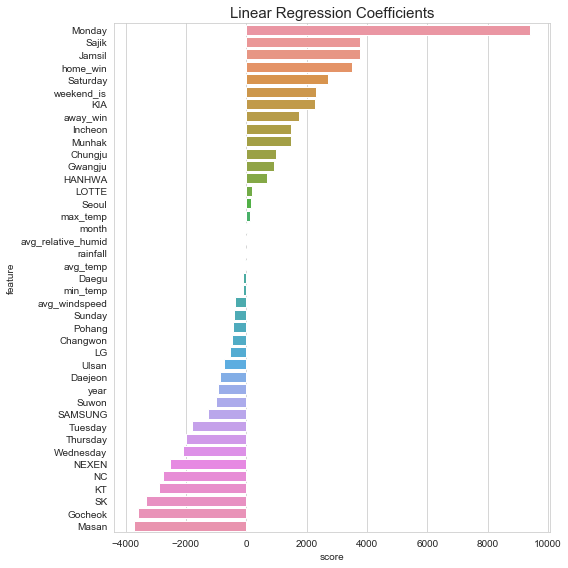

In [26]:
plt.figure(figsize=(8,8))
f_score = pd.DataFrame({'feature':x_train.columns, 'score':lr_model.coef_}).sort_values(by='score',ascending=False)
sns.barplot(x='score',y='feature', data=f_score)
plt.title('Linear Regression Coefficients',size=15)
plt.tight_layout()
plt.savefig('../images/LR_features_importance.jpg', dpi=500)
plt.show()

## Model 2 : RandomForest

In [27]:
rf_params = {
    'n_estimators':1000,
    'max_depth': 3
}

In [28]:
rf_model = RandomForestRegressor(**rf_params)
rf_model = rf_model.fit(x_train, y_train)

### Feature score

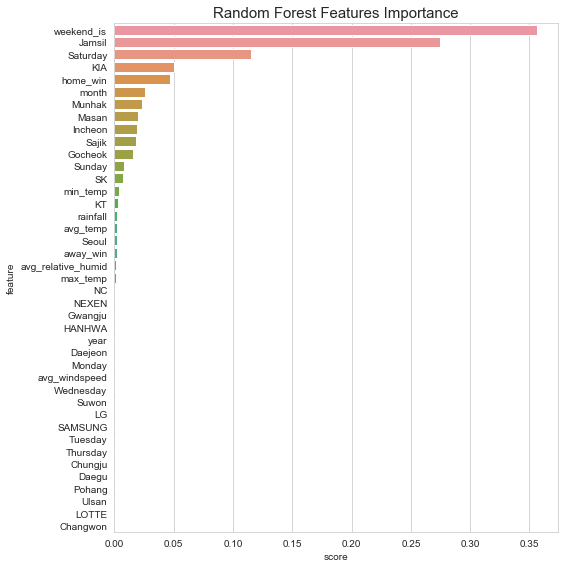

In [29]:
plt.figure(figsize=(8,8))
f_score = pd.DataFrame({'feature':x_train.columns, 'score':rf_model.feature_importances_}).sort_values(by='score',ascending=False)
sns.barplot(x='score',y='feature', data=f_score)
plt.title('Random Forest Features Importance', size=15)
plt.tight_layout()
plt.savefig('../images/RF_features_importance.jpg',dpi=500)
plt.show()

## 평가 [Evaluation]
---
### Test data(평가 데이터)에 대한 예측값을 어떻게 평가할까요?
- 평가의 기준은 문제에 따라 적절한 평가 기준이 필요합니다.
- 평가 기준의 본질을 예측값과 실제값의 차이가 얼마나 나는가입니다.
- 야구 데이터에서는 **`MAE(Mean Absolute Error)`**라는 방법을 통해서 평가할 것 입니다.

> $MAE = \sum_{i} |\hat{y_i}-\bar{y_i}|$

In [30]:
# Validation
lr_valid_prediction = lr_model.predict(x_valid)
lr_valid_mae = metrics.mean_absolute_error(y_valid, lr_valid_prediction).round(2)
rf_valid_prediction = rf_model.predict(x_valid)
rf_valid_mae = metrics.mean_absolute_error(y_valid, rf_valid_prediction).round(2)

# Test
lr_prediction = lr_model.predict(test.drop('nb_crowd',axis=1))
lr_mae = metrics.mean_absolute_error(test.nb_crowd, lr_prediction).round(2)
rf_prediction = rf_model.predict(test.drop('nb_crowd',axis=1))
rf_mae = metrics.mean_absolute_error(test.nb_crowd, rf_prediction).round(2)

Model | Validation MAE | Test MAE
---|---|---
Linear Regression | {{ lr_valid_mae }} | {{ lr_mae }}
Random Forest | {{ rf_valid_mae }} | {{ rf_mae }}

### Test set 평가

In [31]:
idx = np.argmax(test.iloc[:,12:25].values, axis=1)
test_stadium = test.iloc[:,12:25].columns[idx]
test_target = test['nb_crowd']
test_target.index = test_stadium

In [32]:
bar = pye.Bar()
attrs = test_target.index
values = test_target.values
bar.add('실제값', attrs, values)

line = pye.Line()
lr_values = lr_prediction
line.add('LR 예측값',attrs, lr_prediction)
line.add('RF 예측값',attrs, rf_prediction)

overlap1 = pye.Overlap()
overlap1.add(line)
overlap1.add(bar)
overlap1

In [35]:
grid1.render('../images/구장지역특성.html')
grid2.render('../images/요일-평일주말특성.html')
timeline1.render('../images/연도별팀별경기수.html')
page1.render('../images/연도별팀별승률.html')
timeline2.render('../images/시간별날씨변화.html')
timeline3.render('../images/시간별날씨요소와관중수.html')
region_line.render('../images/시간별지역별관중수.html')
stadium_line.render('../images/시간별구장별관중수.html')
crowd_line.render('../images/시간별관중수.html')
overlap1.render('../images/예측값과실제값.html')